In [90]:
import pandas as pd
import os
import matplotlib as mpl
import matplotlib.font_manager as fm
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats
base_dir = os.path.dirname(os.path.abspath(""))
data_folder = os.path.join(base_dir, "data/regular_season")

font_path = "./assets/fonts"
for x in os.listdir(font_path):
    for y in os.listdir(f"{font_path}/{x}"):
        if y.split(".")[-1] == "ttf":
            fm.fontManager.addfont(f"{font_path}/{x}/{y}")
            try:
                fm.FontProperties(weight=y.split("-")[-1].split(".")[0].lower(), fname=y.split("-")[0])
            except Exception:
                continue

plt.style.use("assets/stylesheets/fdp_base.mplstyle")

In [85]:
mpl.rcParams["axes.prop_cycle"]

'white'
'#fcc331'


In [86]:
df = pd.concat([pd.read_csv(os.path.join(data_folder, file_name)) for file_name in os.listdir(data_folder)])

df.shape

(2796750, 15)

In [87]:
df.head()

,draft_id,draft_time,clock,tournament_entry_id,tournament_round_number,player_name,position_name,bye_week,projection_adp,pick_order,overall_pick_number,team_pick_number,pick_points,roster_points,playoff_team
0,00009a0e-b1a6-42e0-b1cf-3f884cc0999b,2021-08-28 17:06:42.031664+00:00,30,e1fdb4f8-4da3-4a09-8e6c-ef294c053251,1,Jalen Reagor,WR,14,139.48,1,144,12,31.2,1613.92,0
1,00009a0e-b1a6-42e0-b1cf-3f884cc0999b,2021-08-28 17:06:42.031664+00:00,30,b1e60f0c-2982-4e5c-8f80-da9a104cb290,1,Marquez Callaway,WR,6,107.46,6,115,10,81.9,1525.06,0
2,00009a0e-b1a6-42e0-b1cf-3f884cc0999b,2021-08-28 17:06:42.031664+00:00,30,b1e60f0c-2982-4e5c-8f80-da9a104cb290,1,Amari Cooper,WR,7,31.75,6,30,3,116.3,1525.06,0
3,00009a0e-b1a6-42e0-b1cf-3f884cc0999b,2021-08-28 17:06:42.031664+00:00,30,5388d065-c260-45cc-b9bf-fcb37f767d2c,1,Rhamondre Stevenson,RB,14,171.55,11,158,14,66.5,1669.72,1
4,00009a0e-b1a6-42e0-b1cf-3f884cc0999b,2021-08-28 17:06:42.031664+00:00,30,5388d065-c260-45cc-b9bf-fcb37f767d2c,1,Darrynton Evans,RB,13,201.35,11,203,17,2.8,1669.72,1


In [173]:
df_copy = df.copy()
df_copy = df_copy.groupby(['player_name', 'position_name'], as_index=False).agg({
    'overall_pick_number': 'mean',
    'pick_points': 'mean'
})

df_copy.head(100)

,player_name,position_name,overall_pick_number,pick_points
0,A.J. Brown,WR,21.190840,88.402834
1,A.J. Green,WR,166.110784,87.699868
2,AJ Dillon,RB,104.656395,95.468706
3,AJ McCarron,QB,160.000000,0.000000
4,Aaron Jones,RB,12.573216,151.479286
...,...,...,...,...
95,Corey Davis,WR,101.539466,74.581287
96,Cornell Powell,WR,205.582359,0.000000
97,Courtland Sutton,WR,69.294254,80.373787
98,Curtis Samuel,WR,91.668057,0.837133


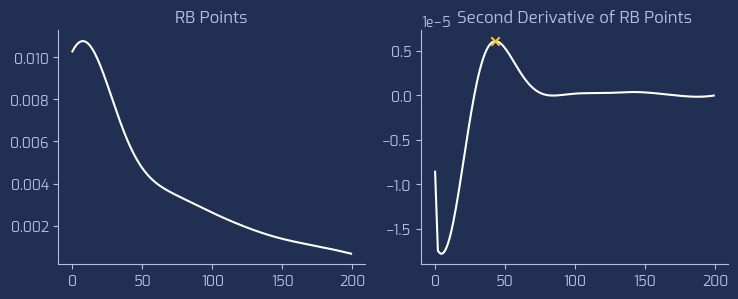

In [175]:
from scipy.ndimage import gaussian_filter1d
from scipy.signal import argrelextrema

rbs = df_copy.loc[df_copy['position_name'] == 'RB']

fig, (ax1, ax2) = plt.subplots(1, 2)

rb_pick_points = rbs['pick_points']
x = np.arange(200)
y = stats.gaussian_kde(rb_pick_points)(x)
x_d2 = np.gradient(np.gradient(y))

ax1.plot(x, y)
ax1.set_title('RB Points')
ax2.plot(x, x_d2)
ax2.set_title('Second Derivative of RB Points')
ax1.grid(False); ax2.grid(False)
ax2.scatter(
    x[argrelextrema(x_d2, np.greater)][0], x_d2[argrelextrema(x_d2, np.greater)][0], marker='x', color='#fcc331', zorder=1000
)
plt.tight_layout()

In [180]:
def calc_replacement_value(pos, ax=False):
    pos_df = df_copy.loc[df_copy['position_name'] == pos]
    pos_df_pick_points = pos_df['pick_points']
    x = np.arange(300)
    y = stats.gaussian_kde(pos_df_pick_points)(x)
    x_d2 = np.gradient(np.gradient(y))
    return x[argrelextrema(x_d2, np.greater)][0]

replacement_values = {}
for position in ['QB', 'RB', 'WR', 'TE', 'FB']:
    replacement_values[position] = calc_replacement_value(position)
    print(
        position, " replacement value: ", calc_replacement_value(position)
    )

QB  replacement value:  53
RB  replacement value:  43
WR  replacement value:  35
TE  replacement value:  32
FB  replacement value:  11


In [184]:
overall_pick_number = df_copy['overall_pick_number']
pick_points = df_copy['pick_points']
position = df_copy['position_name']
df_copy['vor'] = df_copy.apply(lambda x: x['pick_points'] - replacement_values[x['position_name']], axis=1)

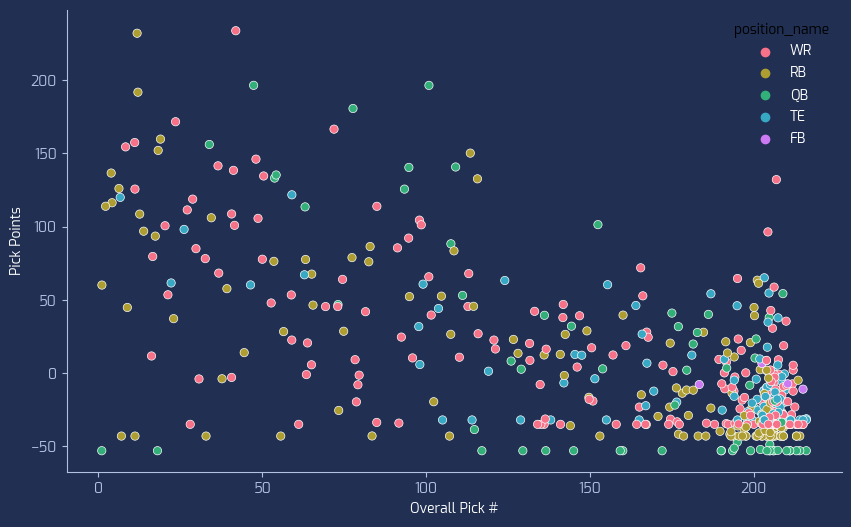

In [183]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.scatterplot(x=overall_pick_number, y=vor, hue=position)
ax.set_xlabel('Overall Pick #', color='white');
ax.set_ylabel('Pick Points', color='white');
ax.grid();

In [187]:
df_copy.sort_values(by='vor', ascending=False).head(15)

,player_name,position_name,overall_pick_number,pick_points,vor
92,Cooper Kupp,WR,41.892725,268.612604,233.612604
276,Jonathan Taylor,RB,11.783055,274.888029,231.888029
284,Josh Allen,QB,47.339666,249.340857,196.340857
491,Tom Brady,QB,100.847467,249.295678,196.295678
36,Austin Ekeler,RB,12.034214,234.648340,191.648340
298,Justin Herbert,QB,77.671918,233.535814,180.535814
300,Justin Jefferson,WR,23.519694,206.505592,171.505592
144,Deebo Samuel,WR,71.878977,201.432113,166.432113
392,Najee Harris,RB,18.926624,202.644790,159.644790
129,Davante Adams,WR,11.054835,192.319393,157.319393
